In [9]:
!git clone https://github.com/optas/artemis.git

Cloning into 'artemis'...
remote: Enumerating objects: 229, done.
remote: Total 229 (delta 0), reused 0 (delta 0), pack-reused 229
Receiving objects: 100% (229/229), 99.43 MiB | 15.53 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [ ]:
%cd artemis
!pip install -e .

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import re
from functools import partial
from ast import literal_eval
from scipy.stats import entropy

from artemis.in_out.basics import show_random_captions
from artemis.emotions import ARTEMIS_EMOTIONS, LARGER_EMOTION_VOCAB, positive_negative_else
from artemis.analysis.emotion_centric import df_to_emotion_histogram, has_emotion_max_dominance
from artemis.evaluation.metaphors import metaphorical_substrings

sns.set()
%load_ext autoreload
%autoreload 2

In [ ]:
!python artemis/scripts/preprocess_artemis_data.py -save-out-dir Dataset -raw-artemis-data-csv '/Dataset/artemis_dataset_release_v0.csv'

{'automatic_spell_check': True,
 'group_gt_anno': True,
 'min_word_freq': 0,
 'n_train_examples': None,
 'preprocess_for_deep_nets': False,
 'random_seed': 2021,
 'raw_artemis_data_csv': '/content/artemis_dataset_release_v0.csv',
 'save_out_dir': 'sample_data',
 'split_loads': [0.85, 0.05, 0.1],
 'too_high_repetition': -1,
 'too_long_utter_prc': 100,
 'too_short_len': 0}
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Traceback (most recent call last):
  File "/content/artemis/artemis/scripts/preprocess_artemis_data.py", line 245, in <module>
    df, vocab, missed_tokens = preprocess(args)
  File "/content/artemis/artemis/scripts/preprocess_artemis_data.py", line 149, in preprocess
    df = pd.read_csv(args.raw_artemis_data_csv)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 912, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/p

In [ ]:
df = pd.read_csv('Dataset/artemis_preprocessed.csv')
df.tokens = df.tokens.apply(literal_eval)
print(f'{len(df)} annotations were loaded.')

In [ ]:
# Add a label to indicate if the emotion is positive or negative or Something-Else
df = df.assign(pne = df.emotion.apply(positive_negative_else))
print("0 for positive; 1 for negative; 2 for something_else")

In [ ]:
# Save preprocessed dataframe to drive
file_path = '/Dataset/with_something_else.csv'
df.to_csv(file_path, index=False)

In [ ]:
# Basic Information of Dataset
average_token_len = df.tokens_len.mean()
print('Average Utterance Length:', average_token_len)

grouped_by_artwork = df.groupby(['painting'])
print('Unique paintings annotated:', len(grouped_by_artwork.size()))
print('Average annotators per painting:', grouped_by_artwork.size().mean())

Average Untterance Length: 15.920549216598781
Unique paintings annotated: 80031
Average annotators per painting: 5.681348477464982


In [ ]:
# Emotion counts
df.groupby(['pne', 'emotion']).size()

pne  emotion       
0    amusement          45336
     awe                72927
     contentment       126134
     excitement         37636
1    anger               6640
     disgust            22411
     fear               41577
     sadness            49061
2    something else     52962
dtype: int64

[<Figure size 1200x400 with 1 Axes>, <Figure size 800x400 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

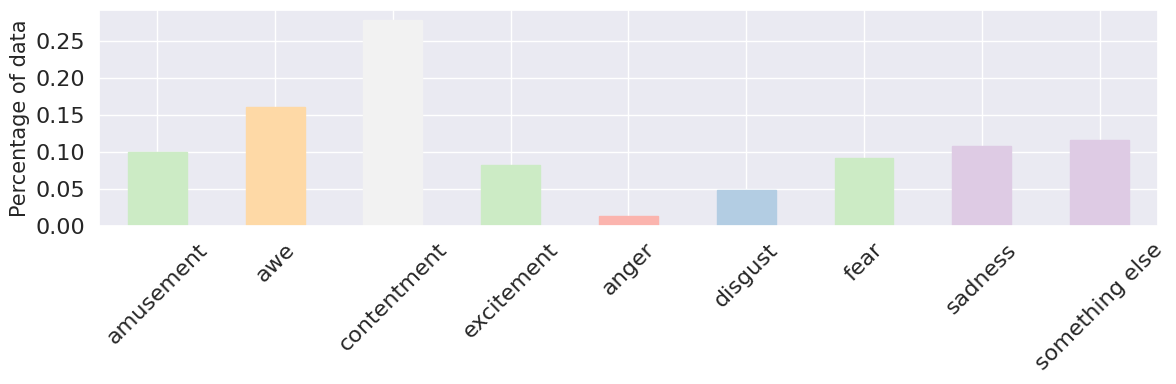

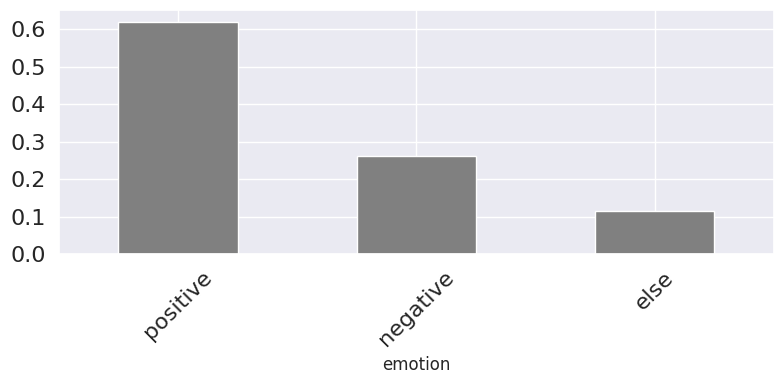

In [ ]:
# Histogram of emotions
df_to_emotion_histogram(df)

## Data Preprocessing

In [ ]:
# read from drive
artemis_csv = '/Dataset/with_something_else.csv'
raw_data = pd.read_csv(artemis_csv)

In [ ]:
raw_data.head()

,art_style,painting,emotion,utterance,repetition,split,tokens,tokens_len,utterance_spelled,tokens_encoded,emotion_label,pne
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"She seems very happy in the picture, and you w...",10,train,"['she', 'seems', 'very', 'happy', 'in', 'the',...",18,she seems very happy in the picture and you wa...,"[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",8,2
1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,sadness,This woman has really knotty hands which makes...,10,train,"['this', 'woman', 'has', 'really', 'knotty', '...",14,this woman has really knotty hands which makes...,"[1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30...",7,1
2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"When looking at this woman, I am filled with c...",10,train,"['when', 'looking', 'at', 'this', 'woman', 'i'...",27,when looking at this woman i am filled with cu...,"[1, 32, 33, 34, 20, 21, 35, 36, 37, 38, 39, 40...",8,2
3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,contentment,"A woman looking at ease, peaceful, and satisfi...",10,train,"['a', 'woman', 'looking', 'at', 'ease', 'peace...",15,a woman looking at ease peaceful and satisfied...,"[1, 45, 21, 33, 34, 48, 49, 11, 50, 51, 28, 52...",2,0
4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,awe,She looks like a lady from that past that migh...,10,train,"['she', 'looks', 'like', 'a', 'lady', 'from', ...",33,she looks like a lady from that past that migh...,"[1, 4, 56, 30, 45, 57, 58, 59, 60, 59, 61, 62,...",1,0


In [ ]:
# distribution according to art style
art_style_counts = raw_data['art_style'].value_counts()
print("Art Style Counts:")
print(art_style_counts)

Art Style Counts:
art_style
Impressionism                 72361
Realism                       59681
Romanticism                   39069
Expressionism                 38717
Post_Impressionism            36374
Art_Nouveau_Modern            24711
Symbolism                     24103
Baroque                       23469
Abstract_Expressionism        16075
Northern_Renaissance          14160
Naive_Art_Primitivism         14086
Rococo                        11904
Cubism                        11462
Color_Field_Painting           9836
Pop_Art                        8438
Early_Renaissance              7622
High_Renaissance               7366
Minimalism                     7163
Mannerism_Late_Renaissance     7047
Ukiyo_e                        6615
Fauvism                        4191
Contemporary_Realism           2953
Pointillism                    2870
New_Realism                    1848
Synthetic_Cubism               1284
Action_painting                 664
Analytical_Cubism               615


In [ ]:
# distribution according to painting
painting_counts = raw_data['painting'].value_counts()
single_instance_paintings = painting_counts[painting_counts == 1].count()

print("\nPainting Counts (Top 10):")
print(painting_counts.head(10))

print("\nNumber of paintings with only one instance:", single_instance_paintings)


Painting Counts (Top 10):
painting
ion-pacea_midnight-sun                                                  58
jackson-pollock_number-17-1949                                          58
a.y.-jackson_spring-caribou-country-1949                                57
childe-hassam_the-flag-outside-her-window-april-aka-boys-marching-by    56
paolo-veronese_perseus-freeing-andromeda-1578                           56
george-morland_thunderstorm                                             56
william-james-glackens_lenna-painting-the-artist-s-daughter-1918        56
mily-possoz_a-la-plage-1920                                             55
mily-possoz_int-rieur-d-atelier-1920                                    55
ion-pacea_white-flowers-and-apples                                      55
Name: count, dtype: int64

Number of paintings with only one instance: 0


In [ ]:
# num of paintings for each art style
art_style_painting_counts = raw_data.groupby('art_style')['painting'].nunique()

print("Art Style Painting Counts:")
print(art_style_painting_counts)

Art Style Painting Counts:
art_style
Abstract_Expressionism         2691
Action_painting                  98
Analytical_Cubism               110
Art_Nouveau_Modern             4272
Baroque                        4239
Color_Field_Painting           1602
Contemporary_Realism            481
Cubism                         2020
Early_Renaissance              1389
Expressionism                  6636
Fauvism                         748
High_Renaissance               1340
Impressionism                 12867
Mannerism_Late_Renaissance     1278
Minimalism                     1254
Naive_Art_Primitivism          2404
New_Realism                     314
Northern_Renaissance           2550
Pointillism                     512
Pop_Art                        1483
Post_Impressionism             6417
Realism                       10726
Rococo                         2087
Romanticism                    6901
Symbolism                      4233
Synthetic_Cubism                216
Ukiyo_e                    

### Load Wikiart dataset

In [ ]:
# load Wikiart dataset: https://www.kaggle.com/datasets/antoinegruson/-wikiart-all-images-120k-link?resource=download
# change the file path to your own
wikiart = '/content/drive/My Drive/EC_Project/wikiart_scraped.csv'
wikiart_img = pd.read_csv(wikiart)
wikiart_img.head()

,Style,Artwork,Artist,Date,Link
0,Early-Dynastic,Narmer Palette,Ancient Egypt,3050 BC,https://uploads3.wikiart.org/00265/images/anci...
1,Early-Dynastic,Box Inlay with a Geometric Pattern,Ancient Egypt,3100-2900 BC,https://uploads2.wikiart.org/00244/images/anci...
2,Old-Kingdom,Khafre Enthroned,Ancient Egypt,2570 BC,https://uploads2.wikiart.org/00305/images/anci...
3,Middle-Kingdom,Stele of the Serpent King (Stela of Djet),Ancient Egypt,3000 BC,https://uploads7.wikiart.org/00305/images/anci...
4,Middle-Kingdom,"Laden Donkeys and Ploughing, Tomb of Djar",Ancient Egypt,2060-2010 BC,https://uploads8.wikiart.org/00244/images/anci...


In [ ]:
def extract_painting_name(link):
  match = re.search(r'images/(.*)\.jpg', link)
  if match:
    return match.group(1).replace('/', '_')
  return None

In [ ]:
# add new column to save the painting name
wikiart_img['painting'] = wikiart_img['Link'].apply(extract_painting_name)

In [ ]:
wikiart_img.head()

,Style,Artwork,Artist,Date,Link,painting
0,Early-Dynastic,Narmer Palette,Ancient Egypt,3050 BC,https://uploads3.wikiart.org/00265/images/anci...,ancient-egyptian-painting_narmer-palette
1,Early-Dynastic,Box Inlay with a Geometric Pattern,Ancient Egypt,3100-2900 BC,https://uploads2.wikiart.org/00244/images/anci...,ancient-egyptian-painting_box-inlay-with-a-geo...
2,Old-Kingdom,Khafre Enthroned,Ancient Egypt,2570 BC,https://uploads2.wikiart.org/00305/images/anci...,ancient-egyptian-painting_330px-khafre-statue
3,Middle-Kingdom,Stele of the Serpent King (Stela of Djet),Ancient Egypt,3000 BC,https://uploads7.wikiart.org/00305/images/anci...,ancient-egyptian-painting_louvre-stele-roi-ser...
4,Middle-Kingdom,"Laden Donkeys and Ploughing, Tomb of Djar",Ancient Egypt,2060-2010 BC,https://uploads8.wikiart.org/00244/images/anci...,ancient-egyptian-painting_laden-donkeys-and-pl...


In [ ]:
wikiart_img.to_csv('/Dataset/wikiart_with_painting.csv', index=False)

### Merge dataset ArtEmis and WikiArt with URL

In [ ]:
merged_data = raw_data.merge(wikiart_img[['painting', 'Link']], on='painting', how='left')

In [ ]:
merged_data.head()

,art_style,painting,emotion,utterance,repetition,split,tokens,tokens_len,utterance_spelled,tokens_encoded,emotion_label,pne,Link
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"She seems very happy in the picture, and you w...",10,train,"['she', 'seems', 'very', 'happy', 'in', 'the',...",18,she seems very happy in the picture and you wa...,"[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",8,2,https://uploads3.wikiart.org/images/vincent-va...
1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,sadness,This woman has really knotty hands which makes...,10,train,"['this', 'woman', 'has', 'really', 'knotty', '...",14,this woman has really knotty hands which makes...,"[1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30...",7,1,https://uploads3.wikiart.org/images/vincent-va...
2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"When looking at this woman, I am filled with c...",10,train,"['when', 'looking', 'at', 'this', 'woman', 'i'...",27,when looking at this woman i am filled with cu...,"[1, 32, 33, 34, 20, 21, 35, 36, 37, 38, 39, 40...",8,2,https://uploads3.wikiart.org/images/vincent-va...
3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,contentment,"A woman looking at ease, peaceful, and satisfi...",10,train,"['a', 'woman', 'looking', 'at', 'ease', 'peace...",15,a woman looking at ease peaceful and satisfied...,"[1, 45, 21, 33, 34, 48, 49, 11, 50, 51, 28, 52...",2,0,https://uploads3.wikiart.org/images/vincent-va...
4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,awe,She looks like a lady from that past that migh...,10,train,"['she', 'looks', 'like', 'a', 'lady', 'from', ...",33,she looks like a lady from that past that migh...,"[1, 4, 56, 30, 45, 57, 58, 59, 60, 59, 61, 62,...",1,0,https://uploads3.wikiart.org/images/vincent-va...


In [ ]:
missing_links = merged_data[merged_data['Link'].isna()]
print("\nMissing Links:")
print(missing_links)


Missing Links:
                 art_style                                        painting  \
7            Impressionism     konstantin-korovin_yaroslavna-s-lament-1909   
8            Impressionism     konstantin-korovin_yaroslavna-s-lament-1909   
11           Impressionism  pericles-pantazis_still-life-with-quinces-1880   
12           Impressionism  pericles-pantazis_still-life-with-quinces-1880   
13           Impressionism                   willard-metcalf_havana-harbor   
...                    ...                                             ...   
467955       Impressionism                   konstantin-korovin_paris-1906   
467997  Art_Nouveau_Modern             tom-thomson_woodland-waterfall-1916   
468002         Romanticism               ivan-aivazovsky_sea-at-night-1861   
468003         Romanticism               ivan-aivazovsky_sea-at-night-1861   
468004         Romanticism               ivan-aivazovsky_sea-at-night-1861   

               emotion                         

In [ ]:
# drop the data instances with no matched URL
cleaned_data = merged_data.dropna(subset=['Link'])

In [ ]:
total_rows = cleaned_data.shape[0]
unique_paintings_count = cleaned_data['painting'].nunique()
print(f"Total Rows: {total_rows}")
print(f"Unique paintings count: {unique_paintings_count}")

Total Rows: 263384
Unique paintings count: 43652


### Process merged dataset

In [ ]:
# remove instance with emotion label "something else"
cleaned_data = cleaned_data[cleaned_data['emotion'] != 'something else']
total_rows = cleaned_data.shape[0]
unique_paintings_count = cleaned_data['painting'].nunique()
print(f"Total Rows: {total_rows}")
print(f"Unique paintings count: {unique_paintings_count}")

Total Rows: 229320
Unique paintings count: 43637


### Reassign emotion labels

In [ ]:
print(cleaned_data.columns)

emotion_count = cleaned_data.groupby('painting')['emotion'].value_counts().unstack(fill_value=0)

print(emotion_count)

Index(['art_style', 'painting', 'emotion', 'utterance', 'repetition', 'split',
       'tokens', 'tokens_len', 'utterance_spelled', 'tokens_encoded',
       'emotion_label', 'pne', 'Link'],
      dtype='object')
emotion                                             amusement  anger  awe  \
painting                                                                    
aaron-siskind_acolman-1-1955                                1      0    0   
aaron-siskind_chicago-1951                                  0      0    1   
aaron-siskind_chicago-6-1961                                0      0    0   
aaron-siskind_feet-102-1957                                 0      0    0   
aaron-siskind_gloucester-16a-1944                           0      0    0   
...                                                       ...    ...  ...   
zinaida-serebriakova_two-peasant-girls-1915                 0      0    0   
zinaida-serebriakova_view-of-the-peter-and-paul...          0      0    1   
zinaida-serebriakov

In [ ]:
emotion_count

emotion,amusement,anger,awe,contentment,disgust,excitement,fear,sadness
painting,,,,,,,,
aaron-siskind_acolman-1-1955,1,0,0,1,0,0,2,0
aaron-siskind_chicago-1951,0,0,1,1,0,0,2,1
aaron-siskind_chicago-6-1961,0,0,0,0,0,0,3,0
aaron-siskind_feet-102-1957,0,0,0,1,2,0,0,0
aaron-siskind_gloucester-16a-1944,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
zinaida-serebriakova_two-peasant-girls-1915,0,0,0,5,0,0,0,0
zinaida-serebriakova_view-of-the-peter-and-paul-fortress-1921,0,0,1,1,1,0,1,1
zinaida-serebriakova_village-neskuchnoye-kursk-province-1916,0,0,1,2,0,0,0,1


In [ ]:
def majority_vote(emotions):
    emotion_counts = emotions.value_counts()
    max_count = emotion_counts.max()
    majority_emotions = emotion_counts[emotion_counts == max_count].index.tolist()
    return majority_emotions

In [ ]:
majority_emotions_df = cleaned_data.groupby('painting')['emotion'].apply(majority_vote).reset_index()
majority_emotions_df.columns = ['painting', 'majority_emotion']

In [ ]:
majority_emotions_df.head(10)

,painting,majority_emotion
0,aaron-siskind_acolman-1-1955,[fear]
1,aaron-siskind_chicago-1951,[fear]
2,aaron-siskind_chicago-6-1961,[fear]
3,aaron-siskind_feet-102-1957,[disgust]
4,aaron-siskind_gloucester-16a-1944,[fear]
5,aaron-siskind_jerome-arizona-1949,"[disgust, fear, anger, contentment]"
6,aaron-siskind_kentucky-4-1951,"[amusement, disgust]"
7,aaron-siskind_new-york-1951,"[disgust, sadness]"
8,aaron-siskind_new-york-2-1948,[fear]
9,aaron-siskind_new-york-24-1988,[fear]


In [ ]:
merged_df = pd.merge(wikiart_img,majority_emotions_df, on='painting')

In [ ]:
merged_df.head(20)

,art_style,painting,emotion,utterance,repetition,split,tokens,tokens_len,utterance_spelled,tokens_encoded,emotion_label,pne,Link,majority_emotion
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,sadness,This woman has really knotty hands which makes...,10,train,"['this', 'woman', 'has', 'really', 'knotty', '...",14,this woman has really knotty hands which makes...,"[1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30...",7,1,https://uploads3.wikiart.org/images/vincent-va...,"[sadness, contentment]"
1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,contentment,"A woman looking at ease, peaceful, and satisfi...",10,train,"['a', 'woman', 'looking', 'at', 'ease', 'peace...",15,a woman looking at ease peaceful and satisfied...,"[1, 45, 21, 33, 34, 48, 49, 11, 50, 51, 28, 52...",2,0,https://uploads3.wikiart.org/images/vincent-va...,"[sadness, contentment]"
2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,awe,She looks like a lady from that past that migh...,10,train,"['she', 'looks', 'like', 'a', 'lady', 'from', ...",33,she looks like a lady from that past that migh...,"[1, 4, 56, 30, 45, 57, 58, 59, 60, 59, 61, 62,...",1,0,https://uploads3.wikiart.org/images/vincent-va...,"[sadness, contentment]"
3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,disgust,The details of the woman's face is off-putting...,10,train,"['the', 'details', 'of', 'the', 'woman', ""'s"",...",13,the details of the woman 's face is off puttin...,"[1, 9, 174, 89, 9, 21, 214, 47, 17, 541, 542, ...",5,1,https://uploads3.wikiart.org/images/vincent-va...,"[sadness, contentment]"
4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,contentment,The warm and happy look on the woman's face ma...,10,train,"['the', 'warm', 'and', 'happy', 'look', 'on', ...",14,the warm and happy look on the woman 's face m...,"[1, 9, 491, 11, 7, 29, 43, 9, 21, 214, 47, 27,...",2,0,https://uploads3.wikiart.org/images/vincent-va...,"[sadness, contentment]"
5,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,fear,the facial features and chiseled painting styl...,10,train,"['the', 'facial', 'features', 'and', 'chiseled...",12,the facial features and chiseled painting styl...,"[1, 9, 905, 202, 11, 9206, 112, 1008, 79, 9, 5...",6,1,https://uploads3.wikiart.org/images/vincent-va...,"[sadness, contentment]"
6,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,sadness,The woman's facial expression seems pretty sad...,10,train,"['the', 'woman', ""'s"", 'facial', 'expression',...",10,the woman 's facial expression seems pretty sa...,"[1, 9, 21, 214, 905, 209, 5, 1000, 641, 11, 17...",7,1,https://uploads3.wikiart.org/images/vincent-va...,"[sadness, contentment]"
7,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,The bright colors make a very unique scene for...,7,train,"['the', 'bright', 'colors', 'make', 'a', 'very...",12,the bright colors make a very unique scene for...,"[1, 9, 77, 78, 79, 45, 6, 80, 81, 73, 9, 82, 8...",1,0,https://uploads0.wikiart.org/images/wassily-ka...,[awe]
8,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,It looks like a large volcano has erupted lava...,7,train,"['it', 'looks', 'like', 'a', 'large', 'volcano...",12,it looks like a large volcano has erupted lava...,"[1, 71, 56, 30, 45, 87, 6971, 22, 21571, 2136,...",1,0,https://uploads0.wikiart.org/images/wassily-ka...,[awe]
9,Expressionism,wassily-kandinsky_study-for-autumn-1909,amusement,The buildings in the lower right look like mal...,7,train,"['the', 'buildings', 'in', 'the', 'lower', 'ri...",15,the buildings in the lower right look like mal...,"[1, 9, 118, 8, 9, 1306, 240, 29, 30, 4012, 990...",0,0,https://uploads0.wikiart.org/images/wassily-ka...,[awe]


In [ ]:
# Filter rows where the majority_emotion column contains only one emotion
single_majority_emotion_count = merged_df[merged_df['majority_emotion'].apply(lambda x: len(x) == 1)].shape[0]

single_majority_emotion_count

173206

In [ ]:
filtered_data_merged_emotion = merged_df[merged_df['majority_emotion'].apply(lambda x: len(x) == 1)]
filtered_data_merged_emotion.head(20)

,art_style,painting,emotion,utterance,repetition,split,tokens,tokens_len,utterance_spelled,tokens_encoded,emotion_label,pne,Link,majority_emotion
7,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,The bright colors make a very unique scene for...,7,train,"['the', 'bright', 'colors', 'make', 'a', 'very...",12,the bright colors make a very unique scene for...,"[1, 9, 77, 78, 79, 45, 6, 80, 81, 73, 9, 82, 8...",1,0,https://uploads0.wikiart.org/images/wassily-ka...,[awe]
8,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,It looks like a large volcano has erupted lava...,7,train,"['it', 'looks', 'like', 'a', 'large', 'volcano...",12,it looks like a large volcano has erupted lava...,"[1, 71, 56, 30, 45, 87, 6971, 22, 21571, 2136,...",1,0,https://uploads0.wikiart.org/images/wassily-ka...,[awe]
9,Expressionism,wassily-kandinsky_study-for-autumn-1909,amusement,The buildings in the lower right look like mal...,7,train,"['the', 'buildings', 'in', 'the', 'lower', 'ri...",15,the buildings in the lower right look like mal...,"[1, 9, 118, 8, 9, 1306, 240, 29, 30, 4012, 990...",0,0,https://uploads0.wikiart.org/images/wassily-ka...,[awe]
10,Expressionism,wassily-kandinsky_study-for-autumn-1909,disgust,I dont like the colors or the style. It looks...,7,train,"['i', 'dont', 'like', 'the', 'colors', 'or', '...",13,i dont like the colors or the style it looks m...,"[1, 35, 6343, 30, 9, 78, 497, 9, 1008, 71, 56,...",5,1,https://uploads0.wikiart.org/images/wassily-ka...,[awe]
11,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,The mountain looks like it has erupted hot magma.,7,train,"['the', 'mountain', 'looks', 'like', 'it', 'ha...",9,the mountain looks like it has erupted hot magma,"[1, 9, 1728, 56, 30, 71, 22, 21571, 295, 19220...",1,0,https://uploads0.wikiart.org/images/wassily-ka...,[awe]
12,Expressionism,wassily-kandinsky_study-for-autumn-1909,amusement,The orange of the mountain looks like it is wr...,7,train,"['the', 'orange', 'of', 'the', 'mountain', 'lo...",19,the orange of the mountain looks like it is wr...,"[1, 9, 955, 89, 9, 1728, 56, 30, 71, 17, 2223,...",0,0,https://uploads0.wikiart.org/images/wassily-ka...,[awe]
13,Impressionism,paul-gauguin_mette-gauguin-in-an-evening-dress...,awe,The golden gloves and white dress stand out an...,7,train,"['the', 'golden', 'gloves', 'and', 'white', 'd...",17,the golden gloves and white dress stand out an...,"[1, 9, 119, 120, 11, 121, 122, 123, 124, 11, 1...",1,0,https://uploads3.wikiart.org/images/paul-gaugu...,[amusement]
14,Impressionism,paul-gauguin_mette-gauguin-in-an-evening-dress...,amusement,The woman is wearing dish-washing gloves even ...,7,train,"['the', 'woman', 'is', 'wearing', 'dish', 'was...",15,the woman is wearing dish washing gloves even ...,"[1, 9, 21, 17, 129, 130, 131, 120, 132, 133, 4...",0,0,https://uploads3.wikiart.org/images/paul-gaugu...,[amusement]
15,Impressionism,paul-gauguin_mette-gauguin-in-an-evening-dress...,sadness,"The woman looks pensive, as though she's conce...",7,train,"['the', 'woman', 'looks', 'pensive', 'as', 'th...",11,the woman looks pensive as though she is conce...,"[1, 9, 21, 56, 1289, 238, 133, 4, 17, 253, 40,...",7,1,https://uploads3.wikiart.org/images/paul-gaugu...,[amusement]
16,Impressionism,paul-gauguin_mette-gauguin-in-an-evening-dress...,contentment,the painting is also a drawing in the applicat...,7,train,"['the', 'painting', 'is', 'also', 'a', 'drawin...",13,the painting is also a drawing in the applicat...,"[1, 9, 112, 17, 1028, 45, 1495, 8, 9, 5671, 89...",2,0,https://uploads3.wikiart.org/images/paul-gaugu...,[amusement]


In [ ]:
# Count the number of unique paintings with one emotion label
unique_paintings_count = filtered_data_merged_emotion['painting'].nunique()
unique_paintings_count

31716

### Data selection and utterance concatenation

In [6]:
data = filtered_data_merged_emotion
df = pd.read_csv(data)
df.head(10)

,art_style,painting,emotion,utterance,repetition,split,tokens,tokens_len,utterance_spelled,tokens_encoded,emotion_label,pne,Link,majority_emotion
0,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,The bright colors make a very unique scene for...,7,train,"['the', 'bright', 'colors', 'make', 'a', 'very...",12,the bright colors make a very unique scene for...,"[1, 9, 77, 78, 79, 45, 6, 80, 81, 73, 9, 82, 8...",1,0,https://uploads0.wikiart.org/images/wassily-ka...,['awe']
1,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,It looks like a large volcano has erupted lava...,7,train,"['it', 'looks', 'like', 'a', 'large', 'volcano...",12,it looks like a large volcano has erupted lava...,"[1, 71, 56, 30, 45, 87, 6971, 22, 21571, 2136,...",1,0,https://uploads0.wikiart.org/images/wassily-ka...,['awe']
2,Expressionism,wassily-kandinsky_study-for-autumn-1909,amusement,The buildings in the lower right look like mal...,7,train,"['the', 'buildings', 'in', 'the', 'lower', 'ri...",15,the buildings in the lower right look like mal...,"[1, 9, 118, 8, 9, 1306, 240, 29, 30, 4012, 990...",0,0,https://uploads0.wikiart.org/images/wassily-ka...,['awe']
3,Expressionism,wassily-kandinsky_study-for-autumn-1909,disgust,I dont like the colors or the style. It looks...,7,train,"['i', 'dont', 'like', 'the', 'colors', 'or', '...",13,i dont like the colors or the style it looks m...,"[1, 35, 6343, 30, 9, 78, 497, 9, 1008, 71, 56,...",5,1,https://uploads0.wikiart.org/images/wassily-ka...,['awe']
4,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,The mountain looks like it has erupted hot magma.,7,train,"['the', 'mountain', 'looks', 'like', 'it', 'ha...",9,the mountain looks like it has erupted hot magma,"[1, 9, 1728, 56, 30, 71, 22, 21571, 295, 19220...",1,0,https://uploads0.wikiart.org/images/wassily-ka...,['awe']
5,Expressionism,wassily-kandinsky_study-for-autumn-1909,amusement,The orange of the mountain looks like it is wr...,7,train,"['the', 'orange', 'of', 'the', 'mountain', 'lo...",19,the orange of the mountain looks like it is wr...,"[1, 9, 955, 89, 9, 1728, 56, 30, 71, 17, 2223,...",0,0,https://uploads0.wikiart.org/images/wassily-ka...,['awe']
6,Impressionism,paul-gauguin_mette-gauguin-in-an-evening-dress...,awe,The golden gloves and white dress stand out an...,7,train,"['the', 'golden', 'gloves', 'and', 'white', 'd...",17,the golden gloves and white dress stand out an...,"[1, 9, 119, 120, 11, 121, 122, 123, 124, 11, 1...",1,0,https://uploads3.wikiart.org/images/paul-gaugu...,['amusement']
7,Impressionism,paul-gauguin_mette-gauguin-in-an-evening-dress...,amusement,The woman is wearing dish-washing gloves even ...,7,train,"['the', 'woman', 'is', 'wearing', 'dish', 'was...",15,the woman is wearing dish washing gloves even ...,"[1, 9, 21, 17, 129, 130, 131, 120, 132, 133, 4...",0,0,https://uploads3.wikiart.org/images/paul-gaugu...,['amusement']
8,Impressionism,paul-gauguin_mette-gauguin-in-an-evening-dress...,sadness,"The woman looks pensive, as though she's conce...",7,train,"['the', 'woman', 'looks', 'pensive', 'as', 'th...",11,the woman looks pensive as though she is conce...,"[1, 9, 21, 56, 1289, 238, 133, 4, 17, 253, 40,...",7,1,https://uploads3.wikiart.org/images/paul-gaugu...,['amusement']
9,Impressionism,paul-gauguin_mette-gauguin-in-an-evening-dress...,contentment,the painting is also a drawing in the applicat...,7,train,"['the', 'painting', 'is', 'also', 'a', 'drawin...",13,the painting is also a drawing in the applicat...,"[1, 9, 112, 17, 1028, 45, 1495, 8, 9, 5671, 89...",2,0,https://uploads3.wikiart.org/images/paul-gaugu...,['amusement']


from matplotlib import pyplot as plt
_df_0['tokens_len'].plot(kind='hist', bins=20, title='tokens_len')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['emotion_label'].plot(kind='hist', bins=20, title='emotion_label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['pne'].plot(kind='hist', bins=20, title='pne')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('art_style').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('painting').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('Link').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='tokens_len', y='emotion_label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='emotion_label', y='pne', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['repetition']
  ys = series['tokens_len']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('repetition', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('art_style')):
  _plot_series(series, series_name, i)
  fig.legend(title='art_style', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('repetition')
_ = plt.ylabel('tokens_len')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['repetition']
  ys = series['tokens_len']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('repetition', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('painting')):
  _plot_series(series, series_name, i)
  fig.legend(title='painting', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('repetition')
_ = plt.ylabel('tokens_len')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['repetition']
  ys = series['tokens_len']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('repetition', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('emotion')):
  _plot_series(series, series_name, i)
  fig.legend(title='emotion', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('repetition')
_ = plt.ylabel('tokens_len')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['repetition']
  ys = series['tokens_len']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('repetition', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Link')):
  _plot_series(series, series_name, i)
  fig.legend(title='Link', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('repetition')
_ = plt.ylabel('tokens_len')

from matplotlib import pyplot as plt
_df_13['tokens_len'].plot(kind='line', figsize=(8, 4), title='tokens_len')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['emotion_label'].plot(kind='line', figsize=(8, 4), title='emotion_label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['pne'].plot(kind='line', figsize=(8, 4), title='pne')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['painting'].value_counts()
    for x_label, grp in _df_16.groupby('art_style')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('art_style')
_ = plt.ylabel('painting')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['emotion'].value_counts()
    for x_label, grp in _df_17.groupby('painting')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('painting')
_ = plt.ylabel('emotion')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Link'].value_counts()
    for x_label, grp in _df_18.groupby('emotion')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('emotion')
_ = plt.ylabel('Link')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['majority_emotion'].value_counts()
    for x_label, grp in _df_19.groupby('Link')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Link')
_ = plt.ylabel('majority_emotion')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['art_style'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='tokens_len', y='art_style', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['painting'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='tokens_len', y='painting', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['emotion'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='tokens_len', y='emotion', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['Link'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='tokens_len', y='Link', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [7]:
# assign the majority emotion label
filtered_df = df[df.apply(lambda row: row['emotion'] in row['majority_emotion'], axis=1)]
filtered_df.head()

,art_style,painting,emotion,utterance,repetition,split,tokens,tokens_len,utterance_spelled,tokens_encoded,emotion_label,pne,Link,majority_emotion
0,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,The bright colors make a very unique scene for...,7,train,"['the', 'bright', 'colors', 'make', 'a', 'very...",12,the bright colors make a very unique scene for...,"[1, 9, 77, 78, 79, 45, 6, 80, 81, 73, 9, 82, 8...",1,0,https://uploads0.wikiart.org/images/wassily-ka...,['awe']
1,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,It looks like a large volcano has erupted lava...,7,train,"['it', 'looks', 'like', 'a', 'large', 'volcano...",12,it looks like a large volcano has erupted lava...,"[1, 71, 56, 30, 45, 87, 6971, 22, 21571, 2136,...",1,0,https://uploads0.wikiart.org/images/wassily-ka...,['awe']
4,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,The mountain looks like it has erupted hot magma.,7,train,"['the', 'mountain', 'looks', 'like', 'it', 'ha...",9,the mountain looks like it has erupted hot magma,"[1, 9, 1728, 56, 30, 71, 22, 21571, 295, 19220...",1,0,https://uploads0.wikiart.org/images/wassily-ka...,['awe']
7,Impressionism,paul-gauguin_mette-gauguin-in-an-evening-dress...,amusement,The woman is wearing dish-washing gloves even ...,7,train,"['the', 'woman', 'is', 'wearing', 'dish', 'was...",15,the woman is wearing dish washing gloves even ...,"[1, 9, 21, 17, 129, 130, 131, 120, 132, 133, 4...",0,0,https://uploads3.wikiart.org/images/paul-gaugu...,['amusement']
12,Impressionism,paul-gauguin_mette-gauguin-in-an-evening-dress...,amusement,It looks like this woman is wearing rubber glo...,7,train,"['it', 'looks', 'like', 'this', 'woman', 'is',...",19,it looks like this woman is wearing rubber glo...,"[1, 71, 56, 30, 20, 21, 17, 129, 16134, 120, 1...",0,0,https://uploads3.wikiart.org/images/paul-gaugu...,['amusement']


In [16]:
# Group by painting and concatenate the utterances
grouped_df = filtered_df.groupby('painting').agg({
    'art_style': 'first',
    'emotion': 'first',
    'repetition': 'first',
    'emotion_label': 'first',
    'pne': 'first',
    'Link': 'first',
    'utterance': ' '.join
}).reset_index()

In [17]:
grouped_df.head(10)

,painting,art_style,emotion,repetition,emotion_label,pne,Link,utterance
0,aaron-siskind_acolman-1-1955,Abstract_Expressionism,fear,5,6,1,https://uploads7.wikiart.org/images/aaron-sisk...,Lost in a city and finding myself in a bad are...
1,aaron-siskind_chicago-1951,Abstract_Expressionism,fear,6,6,1,https://uploads5.wikiart.org/images/aaron-sisk...,looks like some sort of creature from a scary ...
2,aaron-siskind_chicago-6-1961,Abstract_Expressionism,fear,5,6,1,https://uploads7.wikiart.org/images/aaron-sisk...,The black sharp lines running throughout the c...
3,aaron-siskind_feet-102-1957,Abstract_Expressionism,disgust,5,5,1,https://uploads6.wikiart.org/images/aaron-sisk...,Foot looks weird and deformed. I hate feet
4,aaron-siskind_gloucester-16a-1944,Abstract_Expressionism,fear,5,6,1,https://uploads3.wikiart.org/images/aaron-sisk...,"it looks like an eye staring at me, or like a ..."
5,aaron-siskind_new-york-2-1948,Abstract_Expressionism,fear,5,6,1,https://uploads8.wikiart.org/images/aaron-sisk...,the broken glass and sharp points Jagged sharp...
6,aaron-siskind_new-york-24-1988,Abstract_Expressionism,fear,6,6,1,https://uploads0.wikiart.org/images/aaron-sisk...,the hand prints are creepy and horrifying. The...
7,aaron-siskind_new-york-40-1986,Abstract_Expressionism,sadness,5,7,1,https://uploads0.wikiart.org/images/aaron-sisk...,Sadness- this is dark and dreary and just make...
8,aaron-siskind_new-york-city-w-1-1947,Abstract_Expressionism,fear,5,6,1,https://uploads6.wikiart.org/images/aaron-sisk...,Dark pitch black background with jagged gray I...
9,aaron-siskind_per-400-1983,Abstract_Expressionism,fear,5,6,1,https://uploads5.wikiart.org/images/aaron-sisk...,this reminds me of something dark from a horro...


In [18]:
grouped_df.to_csv('/content/drive/My Drive/EC_Project/final_data.csv', index=False)

#### Analysis of filtered final data

In [21]:
# Number of paintings after filtering
n = len(grouped_df.index)
print(f"Number of paintings: {n}")

Number of paintings: 31716


In [19]:
def plot_emotion_label_distribution(df):
  """
  Plot a histogram for the emotion label dsitribution
  """
  plt.figure(figsize=(10,6))
  df['emotion'].value_counts().plot(kind='bar')
  plt.title('Emotion Label Distribution')
  plt.xlabel('Emotion Label')
  plt.ylabel('Count')
  plt.xticks(rotation=45)
  plt.show()

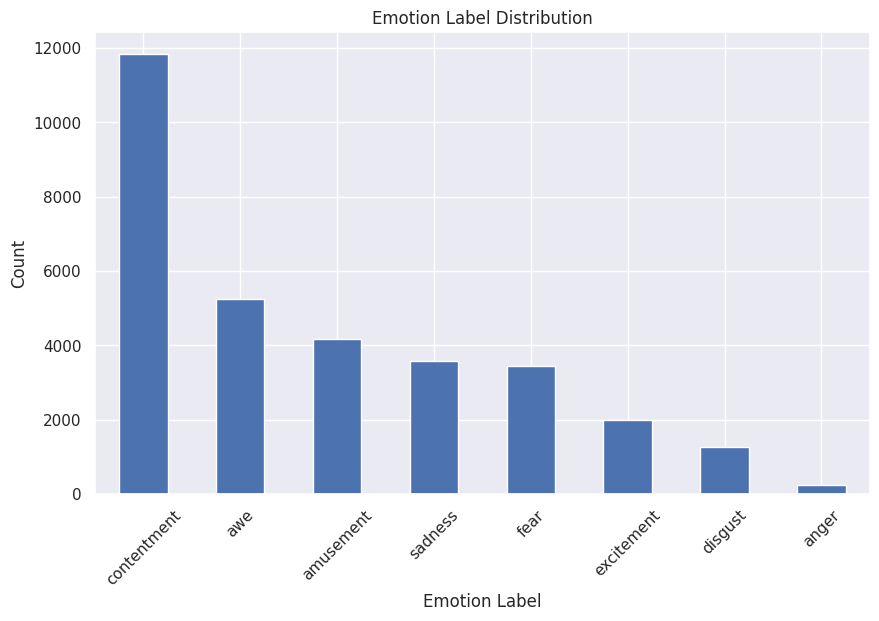

In [20]:
plot_emotion_label_distribution(grouped_df)

In [22]:
def plot_pn_label_distribution(df):
  """
  Plot a histogram for the positive/negative label distribution.
  """
  plt.figure(figsize=(10,6))
  df['pne'].value_counts().plot(kind='bar')
  plt.title('Positive/Negative Label Distribution')
  plt.xlabel('Posive/Negative')
  plt.ylabel('Count')
  plt.xticks(rotation=0)
  plt.show

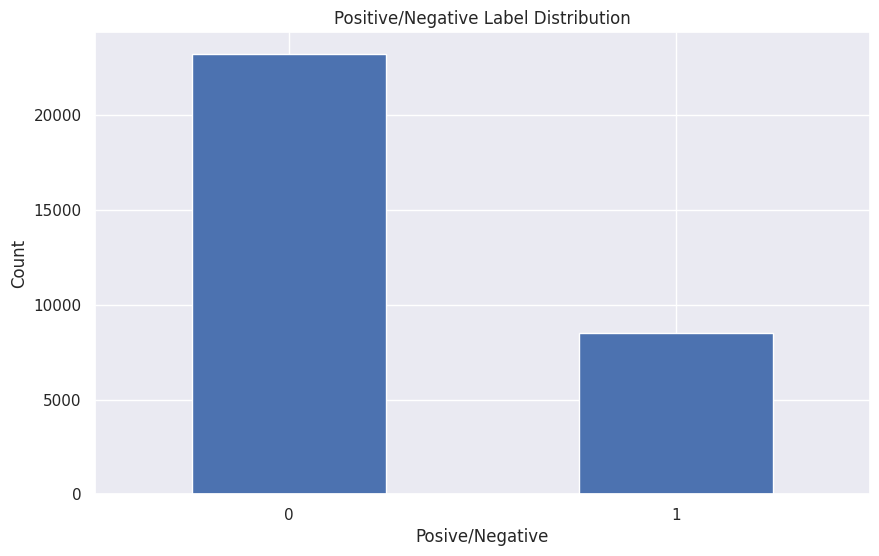

In [23]:
plot_pn_label_distribution(grouped_df)

In [34]:
def plot_emotion_label_per_art_style(df):
  """
  Plot a histogram for the emotion label distribution per art style.
  """
  fig, ax = plt.subplots(figsize=(20, 10))
  df.groupby('art_style')['emotion'].value_counts().unstack().plot(kind='bar', stacked=True, ax=ax)
  plt.title('Emotion Label Distribution per Art Style')
  plt.xlabel('Art Style')
  plt.ylabel('Count')
  ax.legend(title='Emotion Label', bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.xticks(rotation=90, ha='right')
  plt.tight_layout(rect=[0, 0, 0.85, 1])
  plt.show

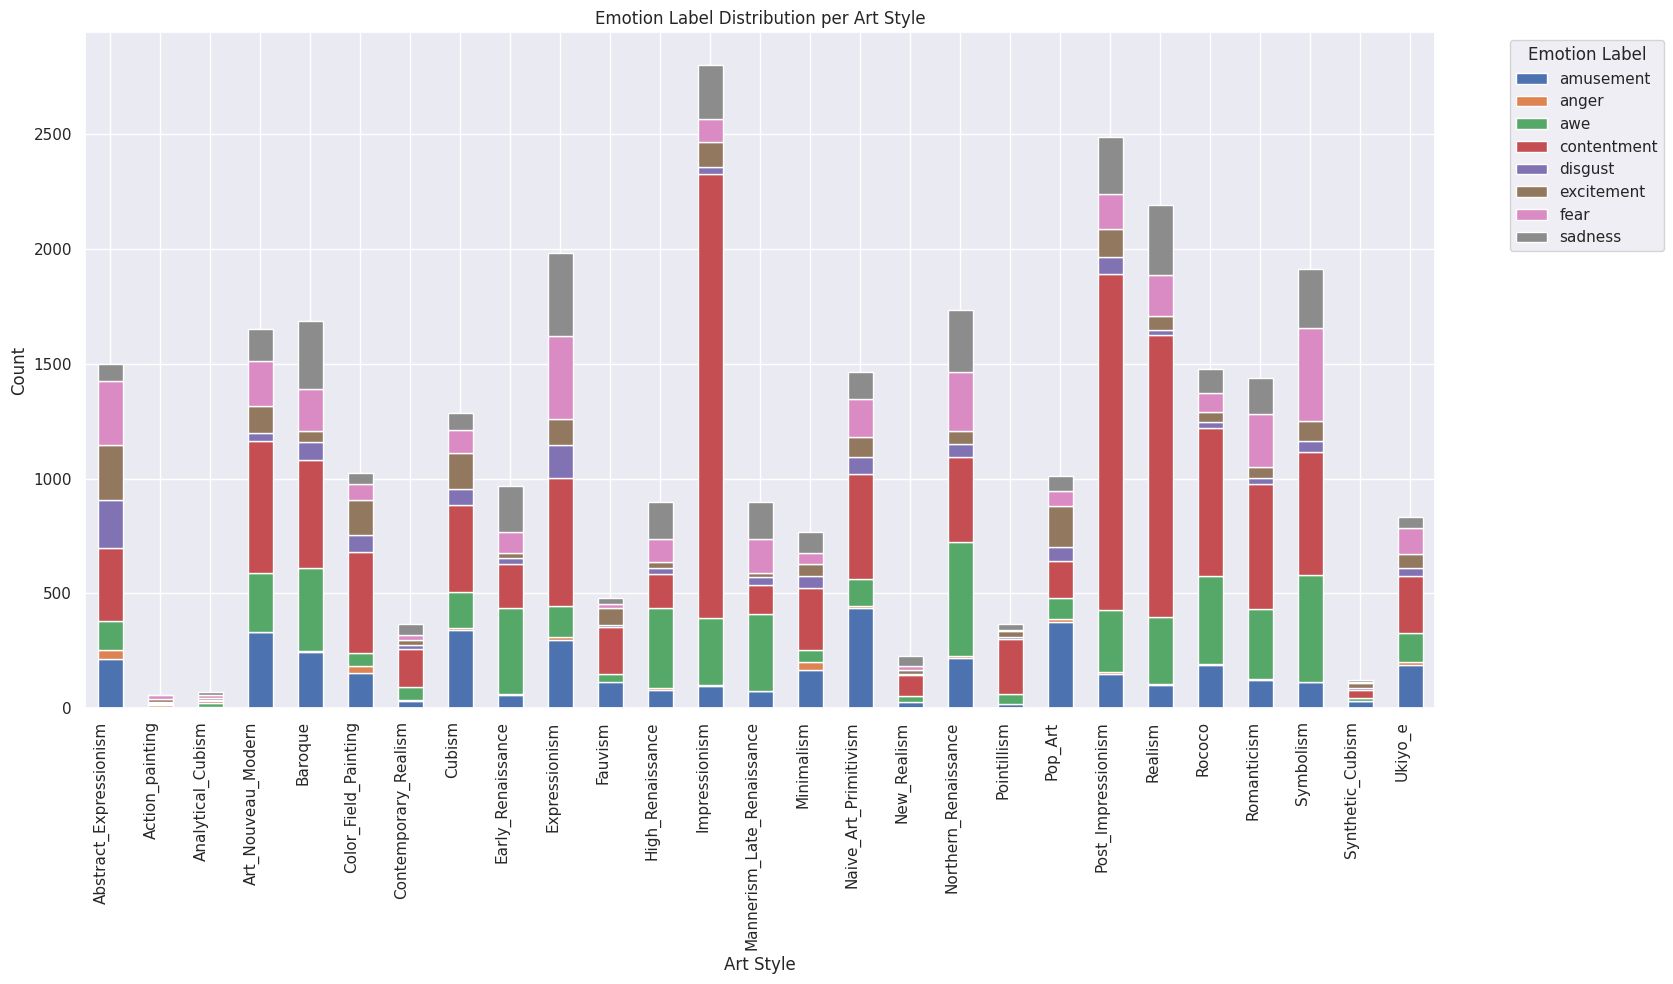

In [35]:
plot_emotion_label_per_art_style(grouped_df)